In [122]:
# Run initialization - all the imported libs, physics variables etc... without ROOT though
%run "/home/elykov/project2_elykov/XENONnT_DAQ/Initialisation_Notebook_no_ROOT.ipynb"

# For pretty fonts :) 
display(HTML("<style>.rendered_html {font-family:Garamond;}</style>")) # add inside {} to change size   font-size: 15px; 

Initialization done, Notebook was last run on: 21/06/2018
hax version 2.4.0


In [55]:
import hax
hax.misc.code_hider()

## <center> Data Transfer Speed Tests with CAEN V1724 Boards</center>

**TO DO:**
 * Do same tests with not square pulses but with gradually decreasing pulses - this will model more accurately what we might encounter - source? -  suggested by Marc  
 * Do these tests with multiple single port PCIe in one machine (2), not a single PCIe with 4 ports.

### 1.  Introduction
This note and its accompanying files (https://github.com/AlexElykov/CAEN_BaordReadout) are aimed at studying data transfer rates for different readout configurations of V1724 CAEN boards;<br>
1. Multiple boards linked to multiple ports of a 4 port PCIe
2. Multiple daisy-chained boards, linked to a sinle port of a PCIe 

### 2. Setup 
**2.1. Configuration of the supplied pulses:**<br>
To reach high data transfer rates of ~ 95 MB/s nim pulses were generated with a Dual Timer module and fanned to a single channel of the V1724 boards - pulse width: 4.8 ms, height: 1.25 V, rate ~ 190 Hz (calculated by me and read by an oscilloscope).<br><br>

**2.2  Information about the CAEN V1724 diitisers [724/VX1724 - User Manual UM3248]**<br>
V1724 is equipped with a VME64 interface (VM64X in case of VX1724) where the data readout can be performed in Single Data Transfer (D32), 32/64-bit Block Transfer (BLT, MBLT, 2eVME. 2eSST) and 32/64-bit Chained Block Transfer (CBLT). The module houses Optical Link interface (CAEN proprietary CONET protocol) supporting transfer rate up to 80 MB/s and offers daisy chain capability. Therefore, it is possible to connect up to 8 ADC modules to a single A2818 Optical Link Controller, or up to 32 using a 4-link A3818 version.<br> 
It should be noted tha all the V1724 digitisers that were used in this work were configured with the settings that are presented in Appendix Table 1, with maximum buffer size of 8 MB.<br><br>

**2.3 Optical Fibres:**<br>
FO cable 62.5/125um OM1 LC/LC 5 m Orange, LCLC62DOR5, FibreFab

In [56]:
path = '/home/elykov/project2_elykov/XENONnT_DAQ/Rate_txt_files/'

In [65]:
# Reading the input files produced by the C++ code txt files
# and converting them to pandas dataframe - cause pandas are aweseome!

def convert_txt_to_h5(txt_name, h5_name, excl0):
    """   
    board_handle = V1724 board number in crate
    bytes = size of the transferred buffer by CAENVME_FIFOBLTReadCycle
    time_span_ns = time that took the CAENVME_FIFOBLTReadCycle to transfer the buffer
    rate_MBs = transfer rate calcualted from the above values for the CAENVME_FIFOBLTReadCycle function in MB/s
    cum_time_span_s = cumulative time that passed since first data transfer for this baord 
    
    output: 
    1. listed pandas dataframes for each board
    2. Cumulative transfer rate in MB each second (i.e. MB/s)
    """
    
    data = pd.read_csv(path + txt_name, sep=" ", header=None, delimiter="\t");
    #data.columns = ["board_handle", "bytes", "time_span_ns", "rate_MBs", "start_t_ns"];
    data.columns = ["board_handle", "bytes", "time_span_ns", "rate_MBs"];

    data.to_hdf(path + h5_name, 'd1');
    if excl0 == 0:
        data = data[data.bytes > 0]
    
    # Separating the total dataframe into a list of df  based on the board handle
    dat_gr = list(data.groupby('board_handle')); 
    
    df_tot_MBs = []
    # Calculating time passed since start of board and adding a column to the dataframe
    for i, k in enumerate(dat_gr):
        dat_gr[i][1]['cum_time_span_s'] =  (dat_gr[i][1]['time_span_ns'].cumsum())/1e9
        #dat_gr[i][1]['time_pass_ns'] =  dat_gr[i][1].start_t_ns[:] - dat_gr[i][1].start_t_ns.iloc[0]
        #dat_gr[i][1]['time_pass_s'] =  (dat_gr[i][1]['time_pass_ns'])/1e9
        
        ix_list = [];
        ind_list = [];
        tot_MBs = [];
        
        df = dat_gr[i][1]
        ix_prev = df.index[0]
        for n in range(140):    # time in seconds to scan... to lazy to do this automatically :P
            #finding closest value to int to find 1s, 2s, 3s,...
            df_sort = df.iloc[(df['cum_time_span_s']-(n+1)).abs().argsort()[:1]]  
            ix = df_sort.index.tolist()
            MBs = df.bytes.loc[ix_prev:ix[0]].sum()/1e6       # summing up byte values between the found indices
            ix_prev = ix[0]
            tot_MBs.append(MBs)
            ix_list.append(n+1)
            df_trs = pd.DataFrame({'transfer_MB':tot_MBs, 'sec':ix_list})
        df_tot_MBs.append(df_trs)
        
    return dat_gr, df_tot_MBs

In [81]:
# Plotting the function transfer rate per sample
def plottin_stuff(dat):
    for i, k in enumerate(dat):
        c = ['b','r','g','m','c']
        plt.plot(dat[i][1].rate_MBs,marker = '.',color = c[i],alpha = 0.5, linestyle = 'None',\
                 label = 'board %i' %i);
        #plt.hlines(np.mean(dat[i][1].rate_MBs),0,len(dat[i][1].rate_MBs)*2,linestyle='-',color = c[i],\
         #          lw = 1, label = 'mean function transfer rate for board %i' %i);
    
    plt.hlines(95,0,7e4, color = 'k' ,linestyle='-', lw = 2, label = '95 MB/s ');
    plt.xlabel('$Cycle\ Samples$', size = 20);        
    plt.ylabel('$Function\ Transfer\ Rate\ [MB/s]$', size = 20);
    plt.legend(loc=4, fontsize = 12);
    plt.ylim(80,98);

In [85]:
# Plotting the function transfer rate per sample
def plottin_bytes_time(dat):
    for i, k in enumerate(dat):
        c = ['b','r','g','m','c']
        plt.plot(dat[i][1].bytes/1e6,marker = '.',color = c[i],alpha = 0.5, linestyle = 'None',\
                 label = 'board %i' %i);
    plt.xlabel('$Cycle\ Samples$', size = 20);        
    plt.ylabel('$Bytes\ Transferred\ [MB]$', size = 20);
    plt.legend(loc=4, fontsize = 12);
    plt.ylim(0.925,1.05); #plt.xlim(0,30);

In [117]:
# Plotting the transferred data size per second
def plottin_tot_transfer(dat):
    for i, k in enumerate(dat):
        c = ['b','r','g','m','c']
        plt.plot(dat[i].sec,dat[i].transfer_MB,marker = '.',color = c[i],alpha = 0.5, linestyle = 'None',\
                 label = 'board %i' %i);
        
    plt.hlines(95,0,160, color = 'k' ,linestyle='-', lw = 2, label = '95 MB ');
    plt.xlabel('$Seconds$', size = 20);        
    plt.ylabel('$Data\ Transfer\ Size\ [MB]$', size = 20);
    plt.legend(loc='center right', fontsize = 12);     
    plt.ylim(86,98);#plt.xlim(0,50);

In [69]:
excl = 1
h5_name = 'Readout_2brd.h5'; txt_name = 'Readout_2brd.txt'; dat2, dat2_t = convert_txt_to_h5(txt_name,h5_name,excl);
h5_name = 'Readout_3brd.h5'; txt_name = 'Readout_3brd.txt'; dat3, dat3_t = convert_txt_to_h5(txt_name,h5_name,excl);
h5_name = 'Readout_4brd.h5'; txt_name = 'Readout_4brd.txt'; dat4, dat4_t = convert_txt_to_h5(txt_name,h5_name,excl);

In [70]:
h5_name = 'Readout_2brd_daisy.h5'; txt_name = 'Daisy_readout_2brd.txt'; dat2_d, dat2_dt = convert_txt_to_h5(txt_name,h5_name,excl);
h5_name = 'Readout_3brd_daisy.h5'; txt_name = 'Daisy_readout_3brd.txt'; dat3_d, dat3_dt = convert_txt_to_h5(txt_name,h5_name,excl);
h5_name = 'Readout_4brd_daisy.h5'; txt_name = 'Daisy_readout_4brd.txt'; dat4_d, dat4_dt = convert_txt_to_h5(txt_name,h5_name,excl);

Runs of approximately 10 minutes were taken with 2, 3 and 4 boards linked to the PCIe with 2,3 and 4 optical fibres, accordingly. The performance of each board was recorded in a .txt file which was then imported to here and converted to a pd format. An example of the resulting data frames, which will be used in Section 3 to perform some basic data analysis. For comparison, 10-minute runs were also taken with 2, 3 and 4 daisy chained boards, each time connected to the PCIe with a single optical link. 

In [110]:
dat4[0][1].tail(5)

,board_handle,bytes,time_span_ns,rate_MBs,cum_time_span_s
57776,0,1011376,10692700.0,94.5857,145.603659
57780,0,952416,10059700.0,94.6766,145.613718
57784,0,952072,10061100.0,94.6291,145.623779
57788,0,952428,10058100.0,94.6923,145.633838
57792,0,951936,10067400.0,94.5563,145.643905


In [72]:
dat4_t[0].tail(5)

,sec,transfer_MB
135,136,95.596016
136,137,95.350036
137,138,95.086752
138,139,95.713216
139,140,95.260596


### 3. Results <br/><br/> 3.a Function Transfer Rates & Performance
In Figure 1 results for timing the data transfer function "CAENVME_FIFOBLTReadCycle" are plotted for reading out a single board and multiple boards with single or multiple optical links into a 4 port PCIe, accordingly. For the board and signal configuration listed in Section 2, each individual cycle (for a single board) takes ~ 0.01 s, taking into account that we in the case of 4 boards loop through them all the actual time between two consecutive readouts of the same board is ~ 0.04 s.

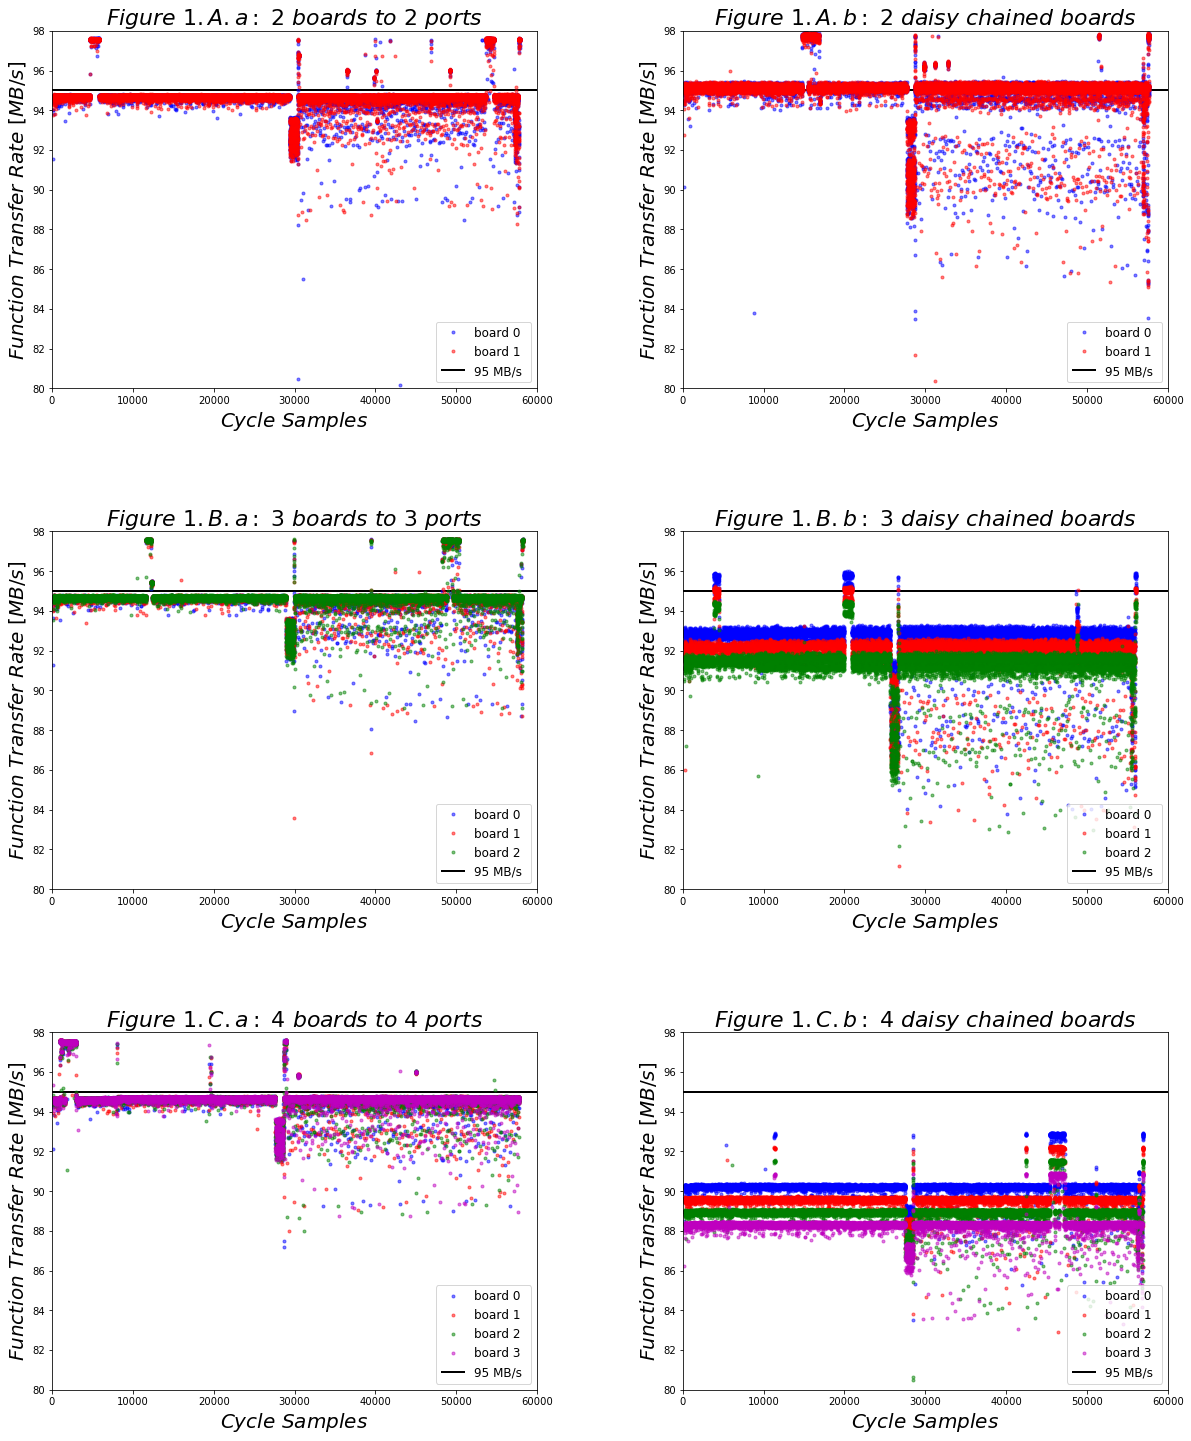

In [99]:
fig = plt.figure(figsize = (20,25), facecolor = 'w')
fig.subplots_adjust(hspace = .4 , wspace =.3)
args = 0,6e4

# 2 boards
ax2 = fig.add_subplot(321)
plt.title('$Figure\ 1.A.a:\ 2\ boards\ to\ 2\ ports$', size = 22);
plottin_stuff(dat2);
plt.xlim(*args);

ax2 = fig.add_subplot(322)
plt.title('$Figure\ 1.A.b:\ 2\ daisy\ chained\ boards$', size = 22);
plottin_stuff(dat2_d);
plt.xlim(*args);

# 3 baords
ax2 = fig.add_subplot(323)
plt.title('$Figure\ 1.B.a:\ 3\ boards\ to\ 3\ ports$', size = 22);
plottin_stuff(dat3);
plt.xlim(*args);

ax2 = fig.add_subplot(324)
plt.title('$Figure\ 1.B.b:\ 3\ daisy\ chained\ boards$', size = 22);
plottin_stuff(dat3_d);
plt.xlim(*args);

# 4 boards
ax2 = fig.add_subplot(325)
plt.title('$Figure\ 1.C.a:\ 4\ boards\ to\ 4\ ports$', size = 22);
plottin_stuff(dat4);
plt.xlim(*args);

ax2 = fig.add_subplot(326)
plt.title('$Figure\ 1.C.b:\ 4\ daisy\ chained\ boards$', size = 22);
plottin_stuff(dat4_d);
plt.xlim(*args);
plt.show()

Figure 2 below, is just a zoom-in of Figure 1 to showcase the drop in transfer rate at ~ 28000 Cycle samples (~5 min).

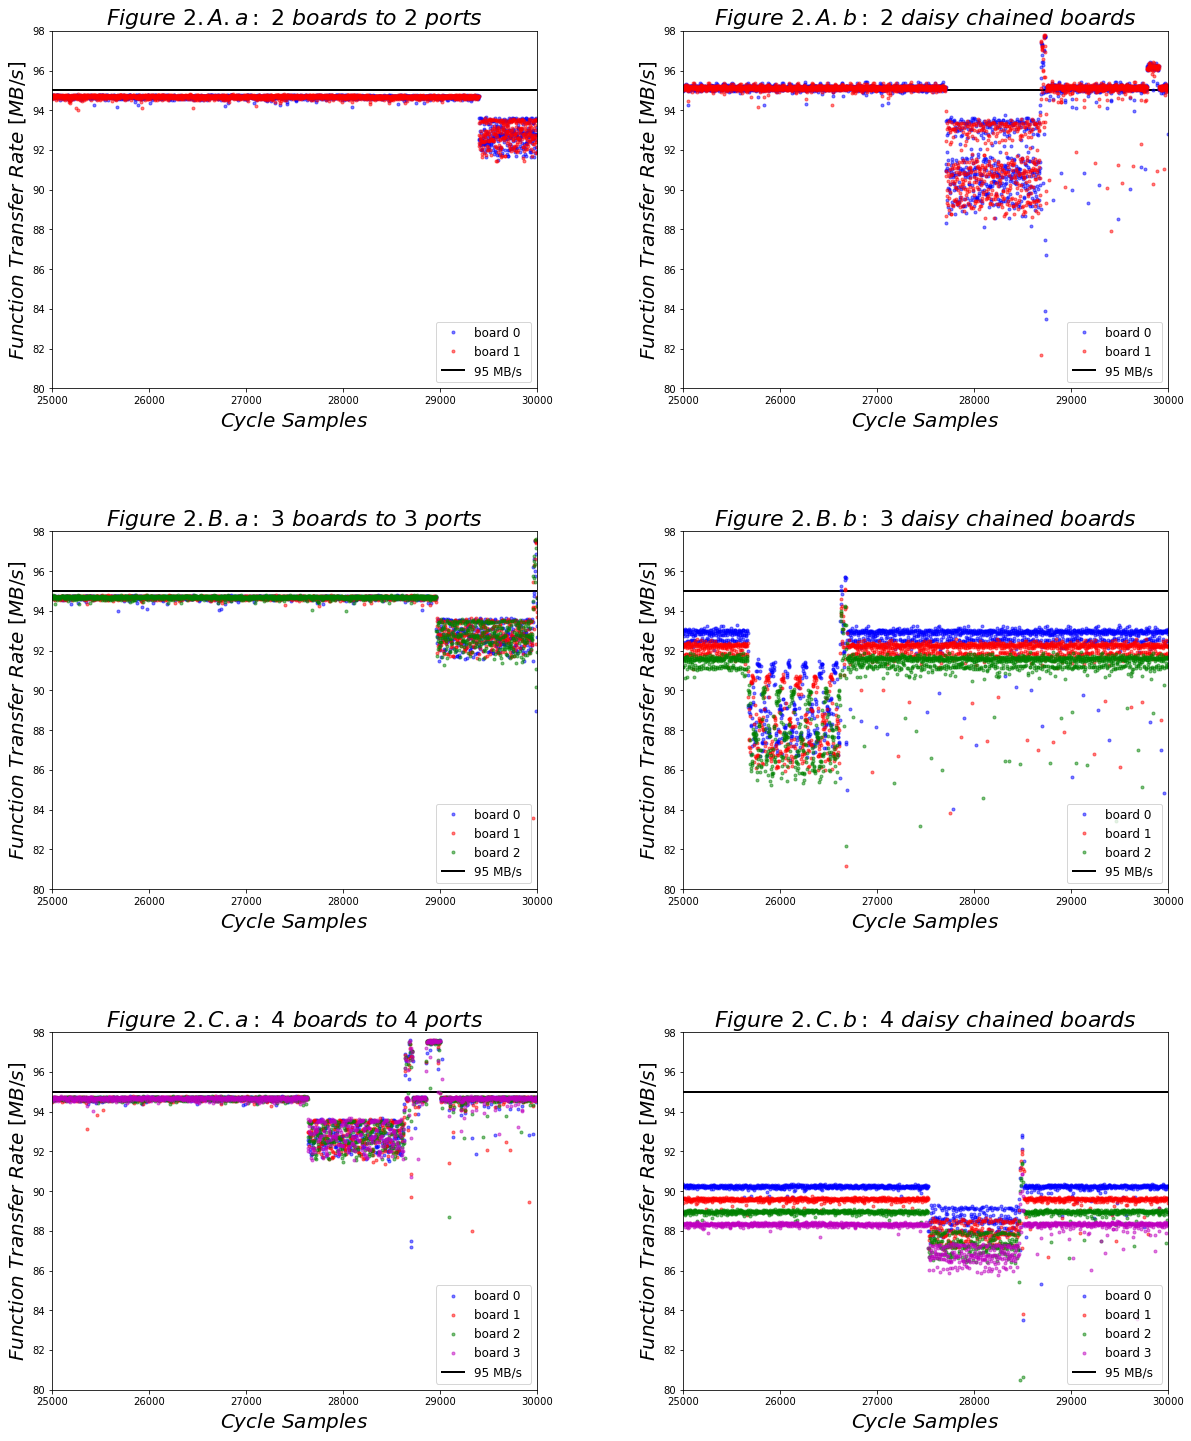

In [116]:
fig = plt.figure(figsize = (20,25), facecolor = 'w')
fig.subplots_adjust(hspace = .4 , wspace =.3)
args = 2.5e4,3e4

# 2 boards
ax2 = fig.add_subplot(321)
plt.title('$Figure\ 2.A.a:\ 2\ boards\ to\ 2\ ports$', size = 22);
plottin_stuff(dat2);
plt.xlim(*args);

ax2 = fig.add_subplot(322)
plt.title('$Figure\ 2.A.b:\ 2\ daisy\ chained\ boards$', size = 22);
plottin_stuff(dat2_d);
plt.xlim(*args);

# 3 baords
ax2 = fig.add_subplot(323)
plt.title('$Figure\ 2.B.a:\ 3\ boards\ to\ 3\ ports$', size = 22);
plottin_stuff(dat3);
plt.xlim(*args);

ax2 = fig.add_subplot(324)
plt.title('$Figure\ 2.B.b:\ 3\ daisy\ chained\ boards$', size = 22);
plottin_stuff(dat3_d);
plt.xlim(*args);

# 4 boards
ax2 = fig.add_subplot(325)
plt.title('$Figure\ 2.C.a:\ 4\ boards\ to\ 4\ ports$', size = 22);
plottin_stuff(dat4);
plt.xlim(*args);

ax2 = fig.add_subplot(326)
plt.title('$Figure\ 2.C.b:\ 4\ daisy\ chained\ boards$', size = 22);
plottin_stuff(dat4_d);
plt.xlim(*args);
plt.show()

Needless to say that the size of the transferred data and transfer times are directly correlated. After bringing the transfer rate of the CAENVME_FIFOBLTReadCycle function to its maximum value ~ 95 MB/s value, increasing the transferred data size will lead to increase in the transfer time, although the transfer rate of the function will still remain ~ 95 MB/s. For example, the time it takes to transfer ~0.9 MB is ~0.01 s, and for ~4 MB it is ~0.05 s.   

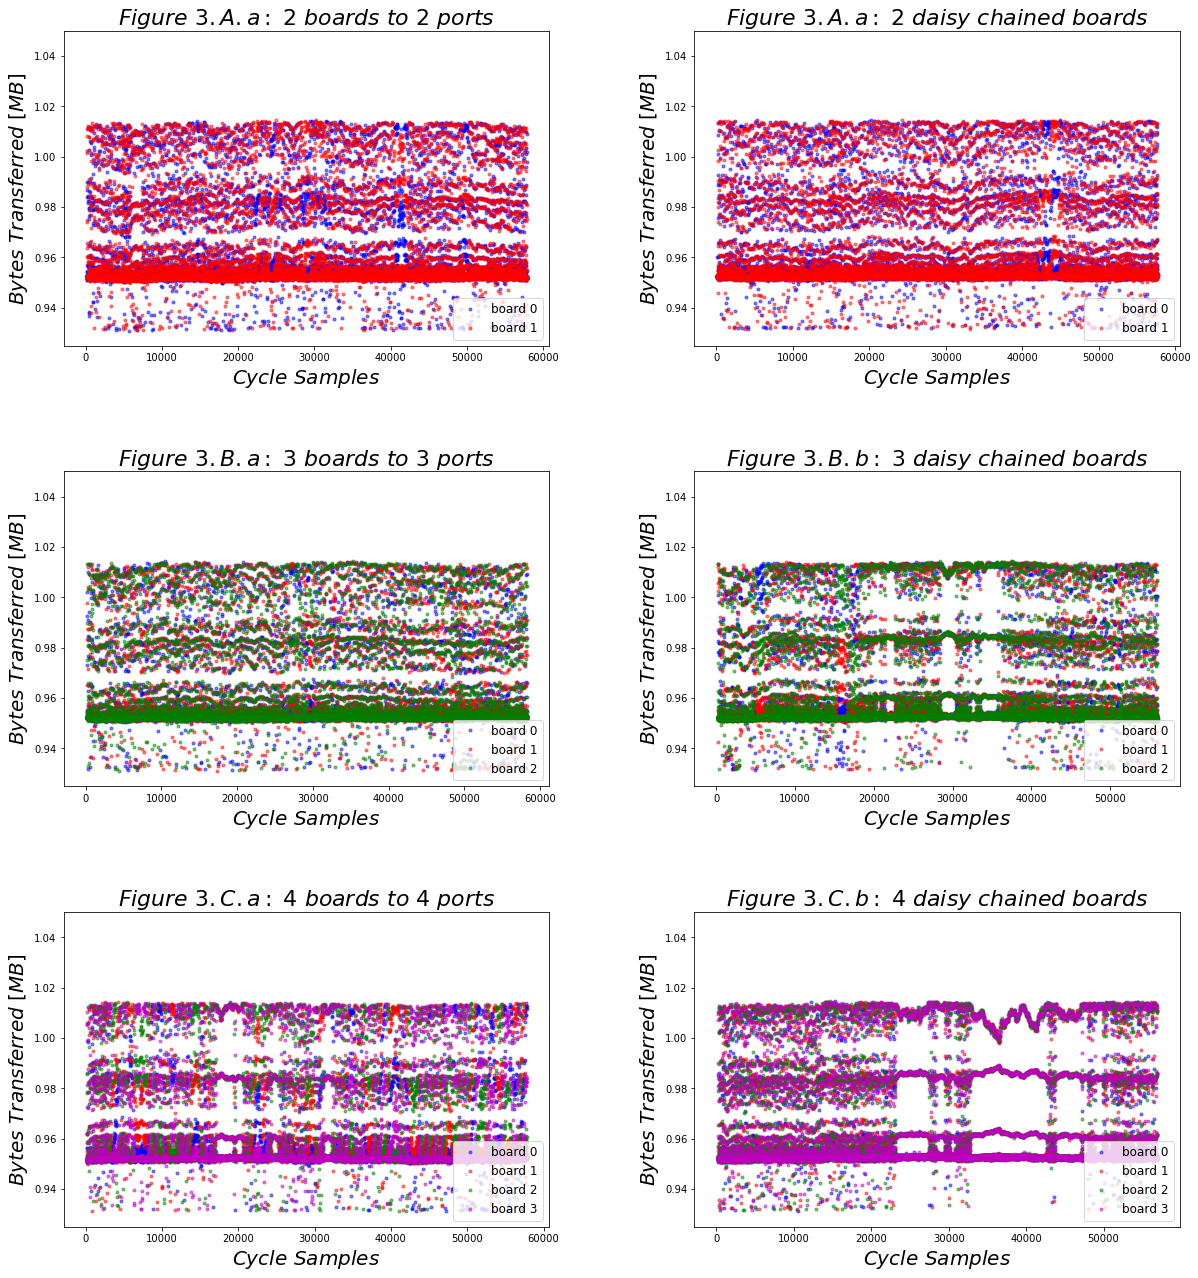

In [97]:
fig = plt.figure(figsize = (20,22), facecolor = 'w')
fig.subplots_adjust(hspace = .4 , wspace =.3)

# 2 board
ax1 = fig.add_subplot(321)
plt.title('$Figure\ 3.A.a:\ 2\ boards\ to\ 2\ ports$', size = 22);
plottin_bytes_time(dat2); 

ax1 = fig.add_subplot(322)
plt.title('$Figure\ 3.A.a:\ 2\ daisy\ chained\ boards$', size = 22);
plottin_bytes_time(dat2_d); 

# 3 boards
ax1 = fig.add_subplot(323)
plt.title('$Figure\ 3.B.a:\ 3\ boards\ to\ 3\ ports$', size = 22);
plottin_bytes_time(dat3); 

ax1 = fig.add_subplot(324)
plt.title('$Figure\ 3.B.b:\ 3\ daisy\ chained\ boards$', size = 22);
plottin_bytes_time(dat3_d); 

# 4 boards
ax1 = fig.add_subplot(325)
plt.title('$Figure\ 3.C.a:\ 4\ boards\ to\ 4\ ports$', size = 22);
plottin_bytes_time(dat4); 

ax1 = fig.add_subplot(326)
plt.title('$Figure\ 3.C.b:\ 4\ daisy\ chained\ boards$', size = 22);
plottin_bytes_time(dat4_d); 
plt.show()

### 3.b Actual Transfer Rates

However, we are actually interested to investigate the actual data transfer rates, i.e. how much data was transferred from each board each second. Hence, in Figure 4, the cumulative data transfer per second for each board. 

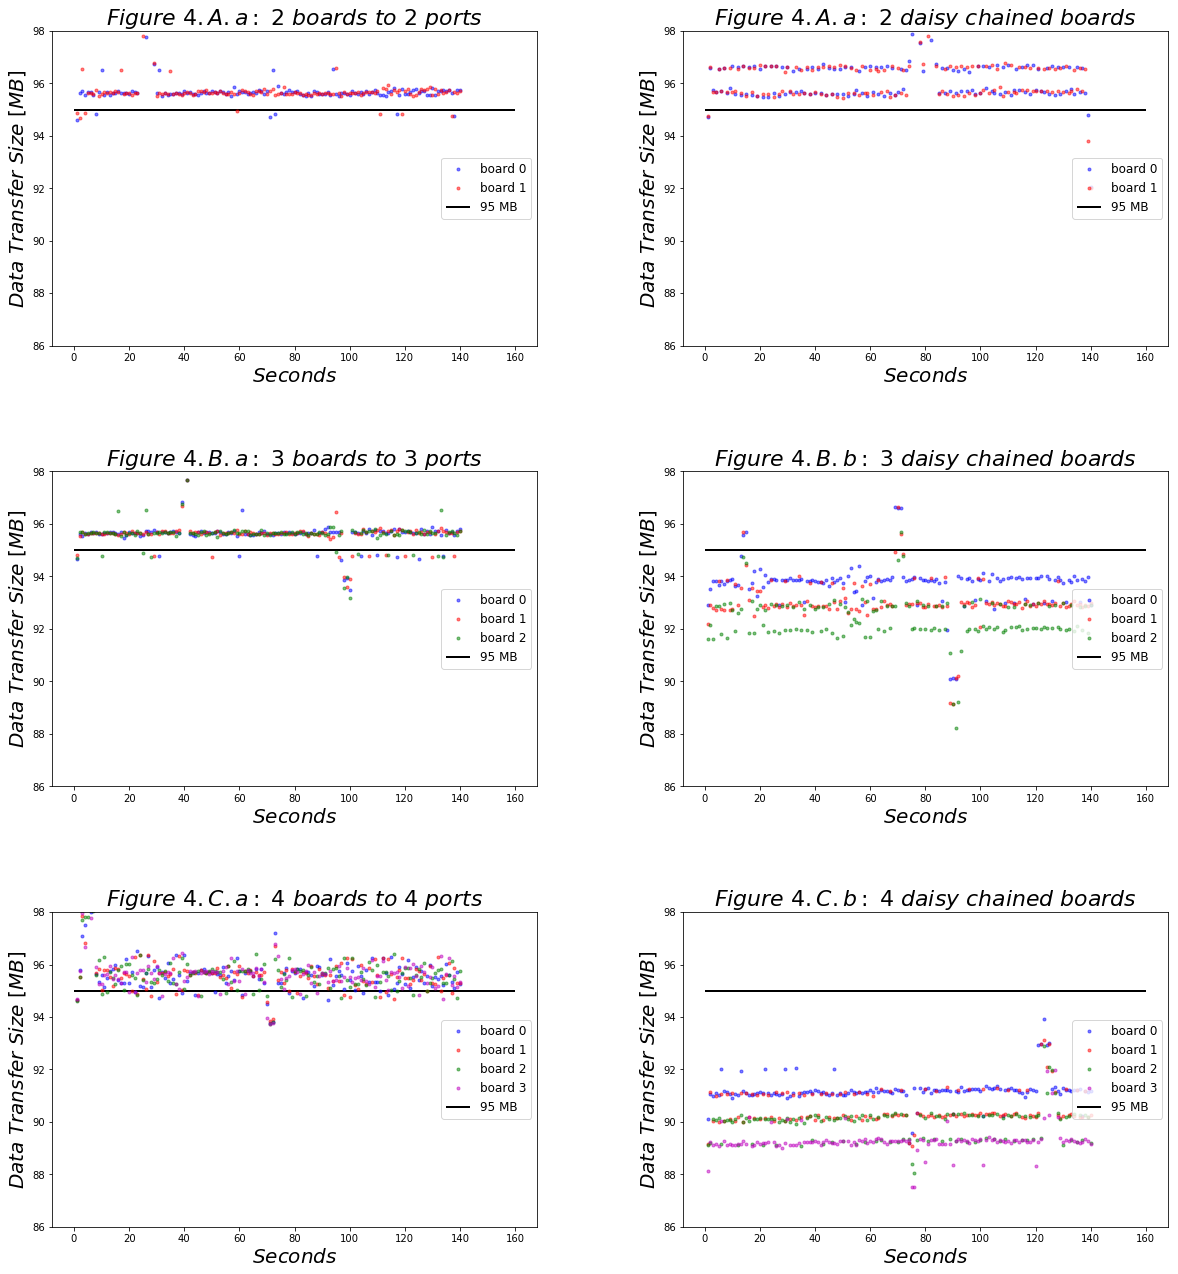

In [118]:
fig = plt.figure(figsize = (20,22), facecolor = 'w')
fig.subplots_adjust(hspace = .4 , wspace =.3)

# 2 board
ax1 = fig.add_subplot(321)
plt.title('$Figure\ 4.A.a:\ 2\ boards\ to\ 2\ ports$', size = 22);
plottin_tot_transfer(dat2_t); 

ax1 = fig.add_subplot(322)
plt.title('$Figure\ 4.A.a:\ 2\ daisy\ chained\ boards$', size = 22);
plottin_tot_transfer(dat2_dt); 

# 3 boards
ax1 = fig.add_subplot(323)
plt.title('$Figure\ 4.B.a:\ 3\ boards\ to\ 3\ ports$', size = 22);
plottin_tot_transfer(dat3_t); 

ax1 = fig.add_subplot(324)
plt.title('$Figure\ 4.B.b:\ 3\ daisy\ chained\ boards$', size = 22);
plottin_tot_transfer(dat3_dt); 

# 4 boards
ax1 = fig.add_subplot(325)
plt.title('$Figure\ 4.C.a:\ 4\ boards\ to\ 4\ ports$', size = 22);
plottin_tot_transfer(dat4_t); 

ax1 = fig.add_subplot(326)
plt.title('$Figure\ 4.C.b:\ 4\ daisy\ chained\ boards$', size = 22);
plottin_tot_transfer(dat4_dt); 
plt.show()

### 4. Summary
Data transfer rates for boards connected to multiple ports of a single multi-port PCIe, don't surpass the rates for the same number of daisy-chained boards connected to a single PCIe port (at least not significantly).

### Appendix

#### Table 1: Values used to set registers in V1724 boards

In [2]:
table = [["REGISTER","VALUE"],["EF24",1],["EF1C",1],
         ["EF00",10],["8120","FF"],["8000",310],["8080",310000],
         ["800C","A"],["8020",258],["811C",110],["8100",0],["81A0",200],
         ["8098",1000],["8038","12C"],["8060","3E8"],["8078","12C"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

REGISTER,VALUE
EF24,1
EF1C,1
EF00,10
8120,FF
8000,310
8080,310000
800C,A
8020,258
811C,110
8100,0
